In [1]:
import pandas as pd
import os
from glob import glob
import json
import re
import numpy as np

In [2]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set output directory
outDIR = './cnn_test_results_downscaled/'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

# set whether to pull full tiles from external disk
#external_path = None
external_path = '/mnt/d/202109'

idx = 0
for d in glob('./cnn_results_deeplabplus*cm'):
    f_list = glob(d + '/best_model_*_validation.txt')
    #f_list = [f for f in f_list if 'downscaled' in f or 'minscaled' in f]
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            val_dat_list = []
            for i in val_dat.split("'"):
                if i == ': False, ':
                    val_dat_list.append(': false, ')
                elif i == ': True, ':
                    val_dat_list.append(': true, ')
                else:
                    val_dat_list.append(i)
            df_tmp = pd.DataFrame(json.loads(re.sub('nan', '"nan"', '"'.join(val_dat_list))), index=[idx])
            df_tmp['model'] = d.split('_')[-1]
            if '2cm' in f:
                df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-1])
            else:
                df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-2])
            df_tmp['min_rp'] = df_tmp[['precision', 'recall']].min(axis=1)
            df_tmp['model_path'] = re.sub('_validation.txt', '.pth', f)
            if idx == 0:
                df_val = df_tmp
            else:
                df_val = pd.concat([df_val, df_tmp])
            idx += 1

In [3]:
df_val

,mccloss,iou_score,accuracy,precision,recall,fscore,fscore_burrow,fscore_old,best_epoch,resolution,model,inputs,min_rp,model_path
0,0.751543,0.547299,0.995195,0.713885,0.745292,0.729251,0.646327,0.605961,12,10.0,10cm,rgb,0.713885,./cnn_results_deeplabplus_10cm/best_model_rgb_...
1,0.835296,0.581482,0.995613,0.922221,0.624319,0.744579,0.667737,0.619348,16,10.0,10cm,"rgb,ndvi",0.624319,./cnn_results_deeplabplus_10cm/best_model_rgb_...
2,0.689485,0.713005,0.996959,0.909635,0.777713,0.838517,0.829476,0.771559,28,10.0,10cm,"rgb,tpi",0.777713,./cnn_results_deeplabplus_10cm/best_model_rgb_...
3,0.684890,0.690937,0.996795,0.882860,0.775757,0.825850,0.807475,0.750287,16,10.0,10cm,"rgb,tpi,ndvi",0.775757,./cnn_results_deeplabplus_10cm/best_model_rgb_...
4,0.744218,0.646823,0.996020,0.866322,0.745928,0.801630,0.783721,0.703955,8,10.0,10cm,tpi,0.745928,./cnn_results_deeplabplus_10cm/best_model_tpi_...
5,0.747721,0.585178,0.996137,0.817710,0.709043,0.759509,0.684637,0.640967,28,15.0,15cm,rgb,0.709043,./cnn_results_deeplabplus_15cm/best_model_rgb_...
6,0.788018,0.548566,0.995727,0.798019,0.671434,0.729274,0.628591,0.598839,24,15.0,15cm,"rgb,ndvi",0.671434,./cnn_results_deeplabplus_15cm/best_model_rgb_...
7,0.754683,0.609243,0.996323,0.867714,0.695406,0.772063,0.732337,0.668785,20,15.0,15cm,"rgb,tpi",0.695406,./cnn_results_deeplabplus_15cm/best_model_rgb_...
8,0.792553,0.521441,0.995386,0.775238,0.672439,0.720189,0.619125,0.573585,36,15.0,15cm,"rgb,tpi,ndvi",0.672439,./cnn_results_deeplabplus_15cm/best_model_rgb_...
9,0.773286,0.507363,0.995654,0.694368,0.721639,0.707741,0.594469,0.567094,16,15.0,15cm,tpi,0.694368,./cnn_results_deeplabplus_15cm/best_model_tpi_...


In [4]:
#df_val['inputs'] = df_val['inputs'].apply(lambda x: re.sub('_', ',', x))
# subset results to only the combos to be evaluated
"""input_list = ['rgb', # RGB only
              'rgb,ndvi', # RGB+Mutli-spectral
              'dsm', # DSM only
              'rgb,dsm', # RGB+DSM
              'rgb,dsm,ndvi', # RGB+DSM+Multi-spectral
             ]
df_val = df_val[df_val['inputs'].isin(input_list)].copy()"""

# drop NDVI-only from 2 cm test
df_val = df_val[df_val['inputs'] != 'ndvi'].copy()

# recompute fscore-beta manually
#df_val['fscore_old'] = df_val['fscore']
#beta = 1.0
#df_val['fscore'] = df_val.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)

In [5]:
df_val.sort_values('fscore', ascending=False).head(30)

,mccloss,iou_score,accuracy,precision,recall,fscore,fscore_burrow,fscore_old,best_epoch,resolution,model,inputs,min_rp,model_path
13,0.750231,0.809255,0.994734,0.918971,0.879875,0.898998,0.927390,0.855758,12,2.0,2cm,"rgb,tpi",0.879875,./cnn_results_deeplabplus_2cm/best_model_rgb_t...
12,0.760360,0.807049,0.993677,0.888068,0.907203,0.897533,0.932558,0.852683,12,2.0,2cm,"rgb,tpi,ndvi",0.888068,./cnn_results_deeplabplus_2cm/best_model_rgb_t...
15,0.778918,0.774820,0.993675,0.899402,0.865157,0.881947,0.886046,0.816999,16,2.0,2cm,tpi,0.865157,./cnn_results_deeplabplus_2cm/best_model_tpi.pth
14,0.788929,0.746163,0.993077,0.886531,0.844183,0.864839,0.860207,0.790437,16,2.0,2cm,rgb,0.844183,./cnn_results_deeplabplus_2cm/best_model_rgb.pth
24,0.716433,0.745073,0.995984,0.885417,0.840286,0.862262,0.867959,0.798667,16,5.0,5cm,"rgb,tpi,ndvi",0.840286,./cnn_results_deeplabplus_5cm/best_model_rgb_t...
11,0.808036,0.741482,0.992263,0.862929,0.850031,0.856431,0.842119,0.780626,12,2.0,2cm,"rgb,ndvi",0.850031,./cnn_results_deeplabplus_2cm/best_model_rgb_n...
23,0.715364,0.734400,0.996456,0.876412,0.831990,0.853623,0.854522,0.784535,20,5.0,5cm,"rgb,tpi",0.831990,./cnn_results_deeplabplus_5cm/best_model_rgb_t...
2,0.689485,0.713005,0.996959,0.909635,0.777713,0.838517,0.829476,0.771559,28,10.0,10cm,"rgb,tpi",0.777713,./cnn_results_deeplabplus_10cm/best_model_rgb_...
25,0.740740,0.706651,0.996069,0.865854,0.797615,0.830335,0.814470,0.752325,20,5.0,5cm,tpi,0.797615,./cnn_results_deeplabplus_5cm/best_model_tpi_5...
3,0.684890,0.690937,0.996795,0.882860,0.775757,0.825850,0.807475,0.750287,16,10.0,10cm,"rgb,tpi,ndvi",0.775757,./cnn_results_deeplabplus_10cm/best_model_rgb_...


### Plot validation results

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='resolution', ylabel='fscore'>

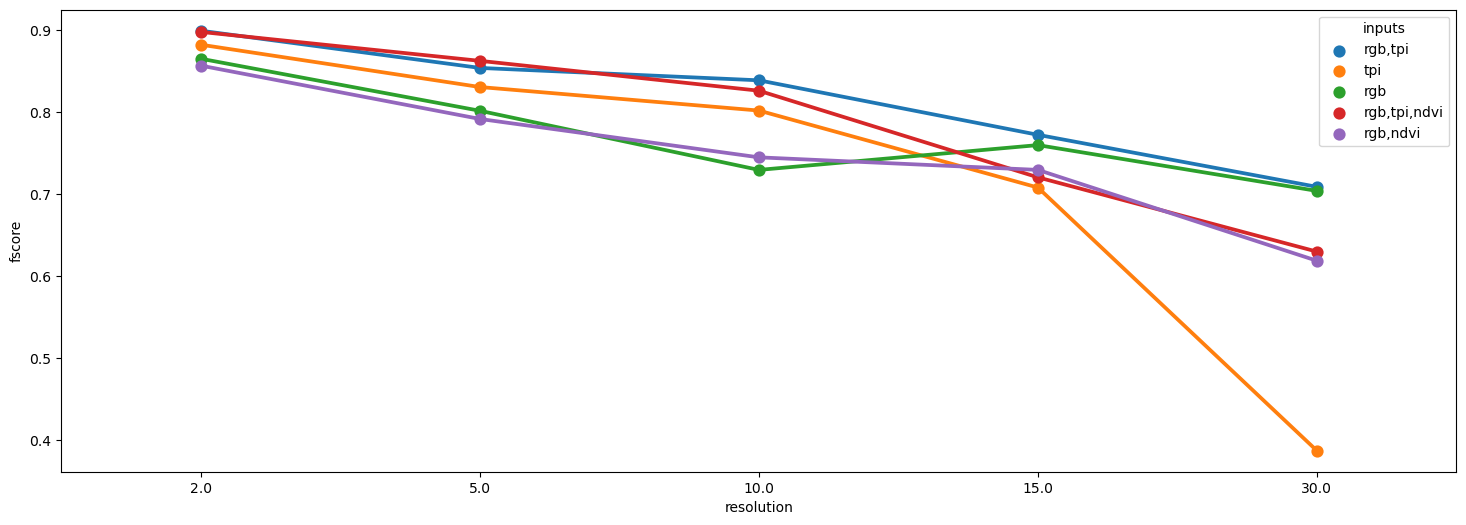

In [7]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.pointplot(x='resolution', y='fscore', 
            hue='inputs',
            data=df_val.sort_values('resolution'),
            ci=None,
            ax=ax)

## Test best model

### Set parameters and datasets

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import gc

In [9]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [10]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)




In [12]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)
    
        

### Quantify and Visualize Test Data Predictions

In [13]:
import itertools
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
import shapely.wkt as wkt
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
from skimage.transform import resize

In [14]:
# helper function for data visualization
def visualize(show=True, write=False, path=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if show:
        plt.show()
    if write:
        plt.savefig(path)
    if not show and write:
        plt.close()

In [15]:
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [16]:
if os.path.exists('./cnn_test_results_downscaled/downscaled_model_test_validation.csv'):
    df_test_out = pd.read_csv('./cnn_test_results_downscaled/downscaled_model_test_validation.csv')
else:
    df_test_out = pd.DataFrame(columns=['model', 'model_resolution', 'inputs',
                                        'test_resolution', 'precision', 'recall', 'fscore', 'correlation'])

In [17]:
df_test_out

,model,model_resolution,inputs,test_resolution,precision,recall,fscore,correlation
0,10cm,10.0,rgb,10.0,0.598566,0.713675,0.651072,0.798362
1,10cm,10.0,"rgb,ndvi",10.0,0.894737,0.418803,0.570548,0.731051
2,10cm,10.0,"rgb,tpi",10.0,0.917127,0.688034,0.786232,0.925400
3,10cm,10.0,"rgb,tpi,ndvi",10.0,0.904255,0.700855,0.789667,0.930405
4,10cm,10.0,tpi,10.0,0.923977,0.662393,0.771618,0.879156
5,15cm,15.0,rgb,15.0,0.676471,0.448718,0.539544,0.691926
6,15cm,15.0,"rgb,ndvi",15.0,0.692810,0.440171,0.538323,0.728500
7,15cm,15.0,"rgb,tpi",15.0,0.920530,0.529915,0.672624,0.852606
8,15cm,15.0,"rgb,tpi,ndvi",15.0,0.830645,0.423077,0.560614,0.776856
9,15cm,15.0,tpi,15.0,0.711656,0.465812,0.563069,0.798376


In [18]:
# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [19]:
print(image_stats)

{'rgb': {'min': 0.0, 'max': 255.0}, 'tpi': {'min': -0.1, 'max': 0.4}, 'ndvi': {'min': 0.0, 'max': 1.0}}


In [20]:
from tqdm import tqdm
from xrspatial import convolution, focal
from skimage.transform import resize
from rasterio.transform import Affine
import xarray as xr
import rioxarray as riox
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-3yoz1c2d', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-3zcnmcon', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-6nggabas', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-atipsjhv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-cflods1h', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-svgn25of', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44297,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:36685,Total threads: 2
Dashboard: http://127.0.0.1:46713/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:38257,


In [21]:
res_chunk_dict = {
    2.0: 256,
    5.0: 160,
    10.0: 128,
    15.0: 96,
    30.0: 64
}

In [22]:
for k in res_chunk_dict:
    buff_size = 64 - 16*int(np.ceil(256/res_chunk_dict[k])) + 16
    print(buff_size)

64
48
48
32
16


In [24]:
preprocess = True
for idx, row in df_val.iterrows():
    print(row[['resolution', 'inputs']])
    res = row['resolution']
    inputs_fnl = row['inputs'].split(',')
    if len(df_test_out[(df_test_out['model_resolution'] == row['resolution']) &
                       (df_test_out['inputs'] ==row['inputs']) &
                       (df_test_out['test_resolution'] == res)]) > 0:
        print('Skipping. Model already validated.')
        continue
    else:
        # load best saved checkpoint
        best_model = torch.load(row['model_path'])
        best_model.eval()

        precision_list = []
        recall_list = []

        burrow_ct_gt = []
        burrow_ct_pred = []
        tile_id_list = []

        for ID in tqdm(df_tiles['ID'][(df_tiles['Train'] == 0) &
                                 (df_tiles['Digitize'] == 1)]):
            if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
                continue
            else:
                # get the path base to the imagery associated with the training tile
                if external_path is None:
                    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
                else:
                    tilePATH = os.path.join(external_path,
                                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
                # get the x/y coordinates of the bounding box for the training polygon within the tile
                box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
                box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
                # get the box coordinate pairs
                ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
                # create a polygon from the coordinate pairs
                tile_geom = Polygon([ll, ul, ur, lr])
                # create the full path to the RGB image of the training tile
                rgb_path = tilePATH + 'rgb.tif'
                with rio.open(rgb_path) as src_rgb:   
                    rgb_out, transform_out = mask.mask(src_rgb,
                                                       [tile_geom],
                                                       crop=True)
                    rgb_out = rgb_out.astype('float')
                    ll_i = src_rgb.index(*ll)
                    ur_i = src_rgb.index(*ur)
                    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                    if len(gdf_polys_sub) > 0:
                        label_mask = rasterize(gdf_polys_sub.geometry, 
                                          out_shape=rgb_out.shape[1:], transform=transform_out,
                                          default_value=1)
                    else:
                         label_mask = np.zeros_like(rgb_out[0, :, :])   
                    newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
                    newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
                    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                     (newsize_r, newsize_c, 3), 
                                     anti_aliasing=True, 
                                     order=1).transpose((2, 0, 1))
                    label_mask = label_mask.astype('float')
                    label_mask = resize(label_mask,
                                     (newsize_r, newsize_c), 
                                     anti_aliasing=True, 
                                     order=1)
                    label_mask = label_mask >= 0.5
                    label_mask = label_mask.astype('int')

                tile_size = res_chunk_dict[res]
                buff_size = 64 - 16*int(np.ceil(256/tile_size)) + 16

                n_row_chunks = int(np.ceil(rgb_out.shape[1]/tile_size))
                n_col_chunks = int(np.ceil(rgb_out.shape[2]/tile_size))

                pr_mask = np.empty_like(rgb_out[0, :, :])
                image_dict = {}
                for suffix in [i for i in inputs_fnl if i != 'rgb']:
                    if suffix != 'tpi':
                        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                            i_out = src_i.read(out_shape=(
                                src_i.count,
                                src_rgb.meta['height'],
                                src_rgb.meta['width']),
                                               resampling=Resampling.bilinear)
                            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
                            image_dict[suffix] = resize(image_dict[suffix].transpose((1, 2, 0)), 
                                                        (newsize_r, newsize_c), 
                                                        anti_aliasing=True, 
                                                        order=1).transpose((2, 0, 1))
                    else:
                        dsm_xr_orig = riox.open_rasterio(re.sub('rgb', 'dsm', rgb_path)).squeeze().chunk({'x': newsize_c/5, 
                                                                                                          'y': newsize_r/5})
                        dsm_xr = dsm_xr_orig.sel(x=slice(box_coords_x[0], box_coords_x[1]),
                                                 y=slice(box_coords_y[1], box_coords_y[0])).rio.reproject(
                            dsm_xr_orig.rio.crs,
                            shape=(newsize_r, newsize_c),
                            resampling=Resampling.bilinear).chunk({'x': newsize_c/5, 
                                                                   'y': newsize_r/5})
                        # get cell size of the the DSM in prep foro TPI calculation
                        cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
                        # prepare an annulus kernel with a ring at the specified distances away from focal point
                        outer_radius = "0.75m"
                        inner_radius = "0.25m"
                        kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
                        # create the TPI image
                        tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)
                        image_dict[suffix] = np.expand_dims(tpi_xr.values, 0)

                image_sub_dict = {}
                for r in range(n_row_chunks):
                    if (r + 1) * tile_size > rgb_out.shape[1]:
                        r_min = rgb_out.shape[1] - tile_size
                        r_max = rgb_out.shape[1]
                        r_max_comp = rgb_out.shape[1]
                    elif (r + 1) * tile_size + buff_size > rgb_out.shape[1]:
                        r_min = r * tile_size
                        r_max = (r + 1) * tile_size
                        r_max_comp = r_max
                    else:
                        r_min = r * tile_size
                        r_max = (r + 1) * tile_size
                        r_max_comp = r_max + buff_size
                    for c in range(n_col_chunks):
                        image_sub_dict = {}
                        if (c + 1) * tile_size > rgb_out.shape[2]:
                            c_min = rgb_out.shape[2] - tile_size
                            c_max = rgb_out.shape[2]
                            c_max_comp = rgb_out.shape[2]
                        elif (c + 1) * tile_size + buff_size > rgb_out.shape[2]:
                            c_min = c * tile_size
                            c_max = (c + 1) * tile_size
                            c_max_comp = c_max
                        else:
                            c_min = c * tile_size
                            c_max = (c + 1) * tile_size
                            c_max_comp = c_max + buff_size
                        #print(r_min, r_max, c_min, c_max)
                        for k in image_dict:
                            image_sub_dict[k] = image_dict[k][:,
                                                              max(0, r_min-buff_size):r_max_comp, 
                                                              max(0, c_min-buff_size):c_max_comp].astype('float32')
                        if 'rgb' in inputs_fnl:
                            image_sub_dict['rgb'] = rgb_out[:, 
                                                            max(0, r_min-buff_size):r_max_comp, 
                                                            max(0, c_min-buff_size):c_max_comp].astype('float32')
                        if preprocess:
                            for i in image_sub_dict:
                                image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                        image_list = [image_sub_dict[i] for i in inputs_fnl]
                        image_out = np.concatenate(image_list, axis=0)
                        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                        if type(best_model) == nn.DataParallel:
                            pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            buff_r_min = buff_size * int(r_min-buff_size > 0)
                            buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                            buff_c_min = buff_size * int(c_min-buff_size > 0)
                            buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                            if pred_tmp.shape[1] > tile_size:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                        else:
                            pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            buff_r_min = buff_size * int(r_min-buff_size > 0)
                            buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                            buff_c_min = buff_size * int(c_min-buff_size > 0)
                            buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                            if pred_tmp.shape[1] > tile_size:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp

                # get regions and properties of the ground truth and predictions
                label_labels = label(label_mask)
                label_regions = regionprops(label_labels)
                pr_labels = label(pr_mask)
                pr_regions = regionprops(pr_labels)

                r_ct_pred = 0
                for r in pr_regions:
                    if r.area*(res/100)**2 > 0.05:
                        y_pr, x_pr = r.centroid
                        precision_list.append(label_mask[int(y_pr), int(x_pr)])
                        r_ct_pred += 1

                r_ct_gt = 0
                for r in label_regions:
                    y_label, x_label = r.centroid
                    recall_list.append(pr_mask[int(y_label), int(x_label)])
                    r_ct_gt += 1
                burrow_ct_gt.append(r_ct_gt)
                burrow_ct_pred.append(r_ct_pred)
                tile_id_list.append(ID)

        precision = np.sum(precision_list) / len(precision_list)
        recall = np.sum(recall_list) / len(recall_list)
        fscore = (2 * precision * recall) / (precision + recall)
        corr = np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]

        df_tmp = pd.DataFrame({
            'model': row['model'],
            'model_resolution': row['resolution'],
            'inputs': row['inputs'],
            'test_resolution': res,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'correlation': corr
        }, index=[idx])

        df_test_out = pd.concat([df_test_out, df_tmp])
        df_test_out.to_csv(os.path.join(outDIR, 'downscaled_model_test_validation.csv'), index=False)
        
        del best_model, df_tmp, precision_list, recall_list, precision, recall
        gc.collect()
        torch.cuda.empty_cache()

resolution    10.0
inputs         rgb
Name: 0, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:07<00:52,  2.48s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [01:56<00:00,  2.59s/it]


resolution        10.0
inputs        rgb,ndvi
Name: 1, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:07<01:05,  3.11s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:13<00:55,  2.91s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution       10.0
inputs        rgb,tpi
Name: 2, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [00:54<00:39,  1.90s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [01:33<00:00,  2.07s/it]


resolution            10.0
inputs        rgb,tpi,ndvi
Name: 3, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:21<01:13,  3.52s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:28<01:02,  3.31s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution    10.0
inputs         tpi
Name: 4, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:12<01:00,  2.89s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:04<00:00,  2.77s/it]


resolution    15.0
inputs         rgb
Name: 5, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [00:56<00:53,  2.56s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [01:46<00:00,  2.38s/it]


resolution        15.0
inputs        rgb,ndvi
Name: 6, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:21<01:09,  3.29s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:27<00:58,  3.06s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution       15.0
inputs        rgb,tpi
Name: 7, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:15<01:05,  3.11s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:07<00:00,  2.84s/it]


resolution            15.0
inputs        rgb,tpi,ndvi
Name: 8, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:34<01:20,  3.86s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:41<01:09,  3.65s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution    15.0
inputs         tpi
Name: 9, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:17<01:06,  3.14s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.11s/it]


resolution         2.0
inputs        rgb,ndvi
Name: 11, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:35<01:21,  3.89s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:42<01:09,  3.66s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution             2.0
inputs        rgb,tpi,ndvi
Name: 12, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [05:37<04:48, 13.72s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [06:06<04:23, 13.88s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution        2.0
inputs        rgb,tpi
Name: 13, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [05:16<04:34, 13.05s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [09:49<00:00, 13.09s/it]


resolution    2.0
inputs        rgb
Name: 14, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:14<01:02,  2.99s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:13<00:00,  2.96s/it]


resolution    2.0
inputs        tpi
Name: 15, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [05:23<04:41, 13.41s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [10:00<00:00, 13.34s/it]


resolution    30.0
inputs         rgb
Name: 16, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:10<00:59,  2.81s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:05<00:00,  2.78s/it]


resolution        30.0
inputs        rgb,ndvi
Name: 17, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:26<01:12,  3.46s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:32<01:02,  3.29s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution       30.0
inputs        rgb,tpi
Name: 18, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:31<01:16,  3.66s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:42<00:00,  3.61s/it]


resolution            30.0
inputs        rgb,tpi,ndvi
Name: 19, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:48<01:31,  4.35s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:55<01:15,  4.00s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution    30.0
inputs         tpi
Name: 20, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:31<01:18,  3.74s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:43<00:00,  3.64s/it]


resolution    5.0
inputs        rgb
Name: 21, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:02<00:50,  2.43s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [01:51<00:00,  2.47s/it]


resolution         5.0
inputs        rgb,ndvi
Name: 22, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:18<01:05,  3.11s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:24<00:55,  2.94s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution        5.0
inputs        rgb,tpi
Name: 23, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:16<01:03,  3.03s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:17<00:00,  3.05s/it]


resolution             5.0
inputs        rgb,tpi,ndvi
Name: 24, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:30<01:17,  3.69s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:37<01:05,  3.47s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

resolution    5.0
inputs        tpi
Name: 25, dtype: object


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:15<01:02,  2.99s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:16<00:00,  3.04s/it]


### Get non-burrow commission error for downscaled

In [23]:
df_bboxes_22E = pd.read_csv('train_tiles/train_bboxes_22E.csv')
df_bboxes_22W = pd.read_csv('train_tiles/train_bboxes_22W.csv')
df_bboxes_5W = pd.read_csv('train_tiles/train_bboxes_5W.csv')
df_bboxes_2930 = pd.read_csv('train_tiles/train_bboxes_29-30.csv')
df_bboxes_CN = pd.read_csv('train_tiles/train_bboxes_CN.csv')
df_bboxes_all = pd.concat([df_bboxes_22E, df_bboxes_22W, df_bboxes_5W, df_bboxes_2930, df_bboxes_CN])

In [24]:
df_bboxes_all = df_bboxes_all[df_bboxes_all['Type'] != 'random'].copy()

In [25]:
df_bboxes_all['path_pre'] = df_bboxes_all.apply(lambda x: os.path.join('train_tiles',
                                                                       '_'.join(x[['Pasture', 'Type']]), 
                                                                       '_'.join(x[['Pasture', 'Tile']]) + '_'), axis=1)

In [26]:
gdf_pdog_burrows = gpd.read_file('ground_data/cper_pdog_points_2021Sept_burrows.shp')
gdf_pdog_other = gpd.read_file('ground_data/cper_pdog_points_2021Sept_other.shp')
gdf_pdog_old = gpd.read_file('ground_data/cper_pdog_points_old_2021Sept.shp')
gdf_pdog_non = gpd.read_file('ground_data/cper_pdog_points_non_2021Sept.shp')
gdf_pdog_points = pd.concat([gdf_pdog_burrows, gdf_pdog_other, gdf_pdog_old, gdf_pdog_non], ignore_index=True)

In [27]:
gdf_plots = gpd.read_file('ground_data/cper_pdog_polys_2021Sept.shp')
gdf_plots_non = gpd.read_file('ground_data/cper_pdog_polys_non_2021Sept.shp')
gdf_plots_old = gpd.read_file('ground_data/cper_pdog_polys_old_2021Sept.shp')
gdf_plots_all = pd.concat([gdf_plots, gdf_plots_non, gdf_plots_old], ignore_index=True)

In [31]:
gdf_pdog_points.columns.to_list()

['Comment',
 'Pasture',
 'height',
 'size',
 'activity',
 'vegetation',
 'is_burrow',
 'geometry']

In [52]:
### Test against ground data
df_error_out = pd.DataFrame(columns=gdf_pdog_points.columns.to_list() + ['pred', 'label', 'model', 'inputs', 'resolution'])
model_fnl = 'deeplabplus'
outDIR = './cnn_test_results_downscaled/'
for idx, row in df_val.iterrows():
    print(row[['resolution', 'inputs']])
    res = row['resolution']
    inputs_fnl = row['inputs'].split(',')
    if len(df_ground_out[(df_ground_out['resolution'] == row['resolution']) &
                       (df_ground_out['inputs'] ==row['inputs'])]) > 0:
        print('Skipping. Model already validated.')
        continue
    else:
        # load best saved checkpoint
        best_model = torch.load(row['model_path'])
        best_model.eval()
        preprocess = True
        df_bboxes_tmp = df_bboxes_all.copy()
        gdf_pdog_points_tmp = gdf_pdog_points.copy()
        print('...running burrow-scale test validation with ground-truth data')
        for ID in tqdm(df_bboxes_all['ID'][df_bboxes_all['Type'] != 'non_burrows']):
            #print(ID)
            # get the path base to the imagery associated with the training tile
            if external_path is None:
                tilePATH = df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0]
            else:
                tilePATH = os.path.join(external_path,
                                        df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0])
            # get the x/y coordinates of the bounding box for the training polygon within the tile
            box_coords_x = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_x', 'max_x']].iloc[0].values
            box_coords_y = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_y', 'max_y']].iloc[0].values
            # get the box coordinate pairs
            ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
            # create a polygon from the coordinate pairs
            tile_geom = Polygon([ll, ul, ur, lr])
            # create the full path to the RGB image of the training tile
            rgb_path = tilePATH + 'rgb.tif'
            with rio.open(rgb_path) as src_rgb:   
                rgb_out, transform_out = mask.mask(src_rgb,
                                                   [tile_geom],
                                                   crop=True)
                rgb_out = rgb_out.astype('float')
                rgb_out_orig = rgb_out.copy()
                ll_i = src_rgb.index(*ll)
                ur_i = src_rgb.index(*ur)
                gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                if len(gdf_polys_sub) > 0:
                    label_mask = rasterize(gdf_polys_sub.geometry, 
                                      out_shape=rgb_out.shape[1:], transform=transform_out,
                                      default_value=1)
                else:
                     label_mask = np.zeros_like(rgb_out[0, :, :])   
                newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
                newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
                rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                 (newsize_r, newsize_c, 3), 
                                 anti_aliasing=True, 
                                 order=1).transpose((2, 0, 1))
                label_mask = label_mask.astype('float')
                label_mask = resize(label_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
                label_mask = label_mask >= 0.5
                label_mask = label_mask.astype('int')
                
            tile_size = res_chunk_dict[res]
            #buff_size = 64 - 16*int(np.ceil(256/tile_size)) + 16

            n_row_chunks = int(np.ceil(rgb_out.shape[1]/tile_size))
            n_col_chunks = int(np.ceil(rgb_out.shape[2]/tile_size))

            pr_mask = np.empty_like(rgb_out[0, :, :])
            image_dict = {}
            for suffix in [i for i in inputs_fnl if i != 'rgb']:
                if suffix != 'tpi':
                    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                        i_out = src_i.read(out_shape=(
                            src_i.count,
                            src_rgb.meta['height'],
                            src_rgb.meta['width']),
                                           resampling=Resampling.bilinear)
                        image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
                        image_dict[suffix] = resize(image_dict[suffix].transpose((1, 2, 0)), 
                                                    (newsize_r, newsize_c), 
                                                    anti_aliasing=True, 
                                                    order=1).transpose((2, 0, 1))
                else:
                    dsm_xr_orig = riox.open_rasterio(re.sub('rgb', 'dsm', rgb_path)).squeeze().chunk({'x': newsize_c/5, 
                                                                                                      'y': newsize_r/5})
                    dsm_xr = dsm_xr_orig.sel(x=slice(box_coords_x[0], box_coords_x[1]),
                                             y=slice(box_coords_y[1], box_coords_y[0])).rio.reproject(
                        dsm_xr_orig.rio.crs,
                        shape=(newsize_r, newsize_c),
                        resampling=Resampling.bilinear).chunk({'x': newsize_c/5, 
                                                               'y': newsize_r/5})
                    # get cell size of the the DSM in prep foro TPI calculation
                    cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
                    # prepare an annulus kernel with a ring at the specified distances away from focal point
                    outer_radius = "0.75m"
                    inner_radius = "0.25m"
                    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
                    # create the TPI image
                    tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)
                    image_dict[suffix] = np.expand_dims(tpi_xr.values, 0)
            if 'rgb' in inputs_fnl:
                    image_dict['rgb'] = rgb_out        
            image_sub_dict = {}
            for r in range(n_row_chunks):
                if (r + 1) * tile_size > rgb_out.shape[1]:
                    r_min = rgb_out.shape[1] - tile_size
                    r_max = rgb_out.shape[1]
                    r_max_comp = rgb_out.shape[1]
                elif (r + 1) * tile_size + buff_size > rgb_out.shape[1]:
                    r_min = r * tile_size
                    r_max = (r + 1) * tile_size
                    r_max_comp = r_max
                else:
                    r_min = r * tile_size
                    r_max = (r + 1) * tile_size
                    r_max_comp = r_max + buff_size
                for c in range(n_col_chunks):
                    image_sub_dict = {}
                    if (c + 1) * tile_size > rgb_out.shape[2]:
                        c_min = rgb_out.shape[2] - tile_size
                        c_max = rgb_out.shape[2]
                        c_max_comp = rgb_out.shape[2]
                    elif (c + 1) * tile_size + buff_size > rgb_out.shape[2]:
                        c_min = c * tile_size
                        c_max = (c + 1) * tile_size
                        c_max_comp = c_max
                    else:
                        c_min = c * tile_size
                        c_max = (c + 1) * tile_size
                        c_max_comp = c_max + buff_size
                    #print(r_min, r_max, c_min, c_max)
                    for k in image_dict:
                        image_sub_dict[k] = image_dict[k][:,
                                                          max(0, r_min-buff_size):r_max_comp, 
                                                          max(0, c_min-buff_size):c_max_comp].astype('float32')
                    if 'rgb' in inputs_fnl:
                        image_sub_dict['rgb'] = rgb_out[:, 
                                                        max(0, r_min-buff_size):r_max_comp, 
                                                        max(0, c_min-buff_size):c_max_comp].astype('float32')
                    if preprocess:
                        for i in image_sub_dict:
                            image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                    image_list = [image_sub_dict[i] for i in inputs_fnl]
                    image_out = np.concatenate(image_list, axis=0)
                    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                    if type(best_model) == nn.DataParallel:
                        pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                    else:
                        pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp

            # create mask of ground-truth polygon
            gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                                     out_shape=rgb_out_orig.shape[1:], 
                                     transform=transform_out,
                                     default_value=1).astype('float')
            gt_plot_mask = resize(gt_plot_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
            gt_plot_mask = gt_plot_mask >= 0.5
            # get predictions for ground-truth points
            gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(tile_geom)]
            if len(gdf_pdog_points_sub) > 0:
                all_points_mask = rasterize(gdf_pdog_points_sub.geometry.buffer(0.5), 
                                              out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                                              default_value=1).astype('float')      
            else:
                all_points_mask = np.zeros_like(rgb_out[0, :, :]) 
            
            all_points_mask = resize(all_points_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
            all_points_mask = all_points_mask >= 0.5
            # mask all arrays to ground-truth polygon
            pr_mask = pr_mask * gt_plot_mask
            label_mask = label_mask * gt_plot_mask
            all_points_mask = all_points_mask * gt_plot_mask


            # get regions and properties of the ground truth and predictions
            label_labels = label(label_mask)
            label_regions = regionprops(label_labels)
            pr_labels = label(pr_mask)
            pr_regions = regionprops(pr_labels)

            ground_pred_precision_list = []
            ground_label_precision_list = []
            r_ct_pred = 0
            for r in pr_regions:
                if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
                    y_pr, x_pr = r.centroid
                    ground_pred_precision_list.append(all_points_mask[int(y_pr), int(x_pr)])
                    r_ct_pred += 1

            r_ct_label = 0
            for r in label_regions:
                y_label, x_label = r.centroid
                ground_label_precision_list.append(all_points_mask[int(y_label), int(x_label)])
                r_ct_label += 1

            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_ct'] = len(ground_pred_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_correct_ct'] = np.sum(ground_pred_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_ct'] = len(ground_label_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_correct_ct'] = np.sum(ground_label_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'gt_ct'] = len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1])

            if len(gdf_pdog_points_sub) > 0:
                for idx, point in gdf_pdog_points_sub.iterrows():
                    point_mask = rasterize([point.geometry.buffer(0.5)], 
                                          out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                                          default_value=1)
                    point_mask = point_mask.astype('float')
                    point_mask = resize(point_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
                    point_mask = point_mask >= 0.5
                    point_labels = label(point_mask)
                    point_regions = regionprops(point_labels)
                    y_gt, x_gt = point_regions[0].centroid
                    gdf_pdog_points_tmp.loc[idx, 'pred'] = pr_mask[int(y_gt), int(x_gt)]
                    gdf_pdog_points_tmp.loc[idx, 'label'] = label_mask[int(y_gt), int(x_gt)]

        df_bboxes_tmp['model'] = model_fnl
        df_bboxes_tmp['inputs'] = '_'.join(inputs_fnl)
        #df_bboxes_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_bbox_gt.csv'), index=False)

        gdf_pdog_points_tmp['model'] = model_fnl
        gdf_pdog_points_tmp['inputs'] = '_'.join(inputs_fnl)
        gdf_pdog_points_tmp['resolution'] = res
        gdf_pdog_points_tmp.to_csv(os.path.join(outDIR, 'test_valid_burrow_gt_' + '_'.join(inputs_fnl) + '_' + str(int(res)) + 'cm.csv'), index=False)
        
        del best_model, df_bboxes_tmp, gdf_pdog_points_tmp
        gc.collect()
        torch.cuda.empty_cache()
    

resolution    10.0
inputs         rgb
Name: 0, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:19<00:43,  3.36s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [02:40<00:18,  3.01s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution        10.0
inputs        rgb,ndvi
Name: 1, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:50<02:52,  3.84s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [00:54<02:43,  3.72s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution       10.0
inputs        rgb,tpi
Name: 2, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:42<00:50,  3.87s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:07<00:21,  3.55s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution            10.0
inputs        rgb,tpi,ndvi
Name: 3, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:56<03:18,  4.42s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:00<03:09,  4.31s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution    10.0
inputs         tpi
Name: 4, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:34<00:48,  3.73s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [02:58<00:20,  3.40s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution    15.0
inputs         rgb
Name: 5, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:27<00:47,  3.65s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [02:50<00:19,  3.23s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution        15.0
inputs        rgb,ndvi
Name: 6, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:56<03:15,  4.34s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:00<03:05,  4.22s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution       15.0
inputs        rgb,tpi
Name: 7, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:57<00:55,  4.29s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:24<00:23,  3.89s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution            15.0
inputs        rgb,tpi,ndvi
Name: 8, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [01:04<03:47,  5.06s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:08<03:31,  4.81s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution    15.0
inputs         tpi
Name: 9, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:53<00:54,  4.22s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:20<00:23,  3.87s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution         2.0
inputs        rgb,ndvi
Name: 11, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:59<03:31,  4.69s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:03<03:19,  4.54s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution             2.0
inputs        rgb,tpi,ndvi
Name: 12, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [02:52<10:43, 14.30s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [03:06<10:24, 14.19s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution        2.0
inputs        rgb,tpi
Name: 13, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [09:45<02:54, 13.45s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [11:18<01:19, 13.24s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution    2.0
inputs        rgb
Name: 14, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:44<00:50,  3.89s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:09<00:21,  3.56s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution    2.0
inputs        tpi
Name: 15, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [09:57<02:56, 13.58s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [11:31<01:19, 13.29s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution    30.0
inputs         rgb
Name: 16, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [03:04<00:57,  4.43s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:32<00:23,  3.93s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution        30.0
inputs        rgb,ndvi
Name: 17, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [01:11<04:02,  5.38s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:15<03:43,  5.09s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution       30.0
inputs        rgb,tpi
Name: 18, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [03:44<01:09,  5.36s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [04:21<00:30,  5.16s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution            30.0
inputs        rgb,tpi,ndvi
Name: 19, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [01:23<04:46,  6.38s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [01:29<04:25,  6.02s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution    30.0
inputs         tpi
Name: 20, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [03:43<01:10,  5.41s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [04:18<00:29,  4.95s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution    5.0
inputs        rgb
Name: 21, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:09<00:42,  3.25s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [02:29<00:17,  2.95s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution         5.0
inputs        rgb,ndvi
Name: 22, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:49<02:49,  3.76s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [00:53<02:42,  3.69s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution        5.0
inputs        rgb,tpi
Name: 23, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:36<00:48,  3.77s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:00<00:20,  3.44s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

resolution             5.0
inputs        rgb,tpi,ndvi
Name: 24, dtype: object
...running burrow-scale test validation with ground-truth data


 21%|██████████████████▉                                                                       | 12/57 [00:55<03:14,  4.32s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|████████████████████▌                                                                     | 13/57 [00:59<03:04,  4.19s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|█████████████████████

resolution    5.0
inputs        tpi
Name: 25, dtype: object
...running burrow-scale test validation with ground-truth data


 77%|█████████████████████████████████████████████████████████████████████▍                    | 44/57 [02:36<00:49,  3.82s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|████████████████████████████████████████████████████████████████████████████████▌         | 51/57 [03:01<00:21,  3.51s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|█████████████████████

In [51]:
gdf_pdog_points_tmp.to_csv(os.path.join(outDIR, 'test_valid_burrow_gt_' + '_'.join(inputs_fnl) + '_' + str(int(res)) + 'cm.csv'), index=False)

In [44]:
df_error_out.to_csv(os.path.join(outDIR, 'test_valid_burrow_gt_' + str(int(res)) + 'cm.csv'), index=False)

In [41]:
model_fnl = 'deeplabplus'
outDIR = './cnn_test_results_downscaled/'
gdf_pdog_points_tmp['model'] = model_fnl
gdf_pdog_points_tmp['inputs'] = '_'.join(inputs_fnl)
gdf_pdog_points_tmp['resolution'] = res
gdf_pdog_points_tmp.to_csv(os.path.join(outDIR, 'test_valid_burrow_gt_' + str(int(res)) + 'cm.csv'), index=False)

In [25]:
print('Processing complete!')

Processing complete!


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

In [75]:
tile_size

160

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-84ehygkc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/da

In [53]:
#max(0, r_min-buff_size)#:
min(rgb_out.shape[1], r_max+buff_size)

300

In [57]:
r_max+buff_size 

304

In [68]:
inputs_fnl = ['rgb']

best_model = torch.load('./cnn_results_deeplabplus_15cm/best_model_rgb_15cm.pth')
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

dsm_test = rio.open('/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/cnn_train_images_10cm/poly_1_CN_burrows_active_23_dsm.tif').read()
tpi_test = rio.open('/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/cnn_train_images_10cm/poly_1_CN_burrows_active_23_tpi.tif').read()
rgb_test = rio.open('/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/cnn_train_images_10cm/poly_1_CN_burrows_active_23_rgb.tif').read()

image_dict['dsm'] = dsm_test
image_dict['tpi'] = tpi_test
image_dict['rgb'] = rgb_test

if preprocess:
    for i in image_dict:
        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
image_out = np.concatenate(image_list, axis=0)

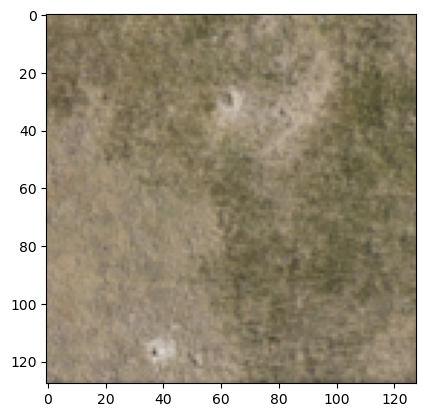

In [69]:
plt.imshow(image_dict['rgb'].transpose((1, 2, 0)))

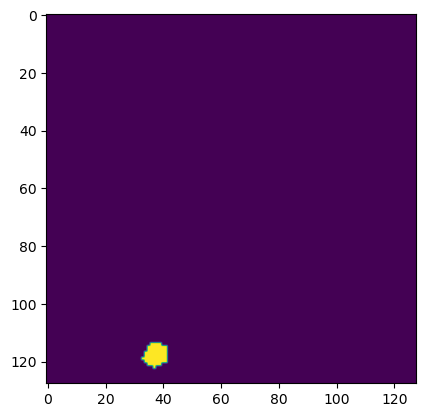

In [70]:
x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= 0.5
plt.imshow(pr_mask)

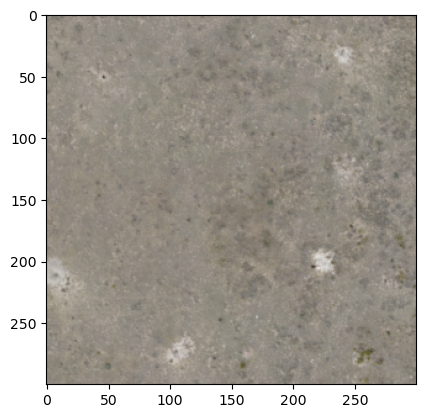

In [66]:
plt.imshow(rgb_out.transpose((1, 2, 0)).astype('int'))

In [76]:
np.max(image_out[2, :, :])

0.87254524

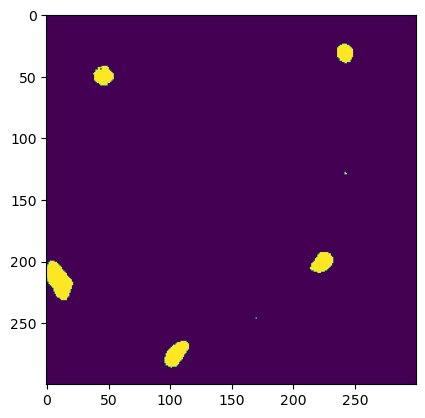

In [71]:
plt.imshow(pr_mask)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_downscaled_test = pd.read_csv('./cnn_test_results_downscaled/downscaled_model_test_validation.csv')

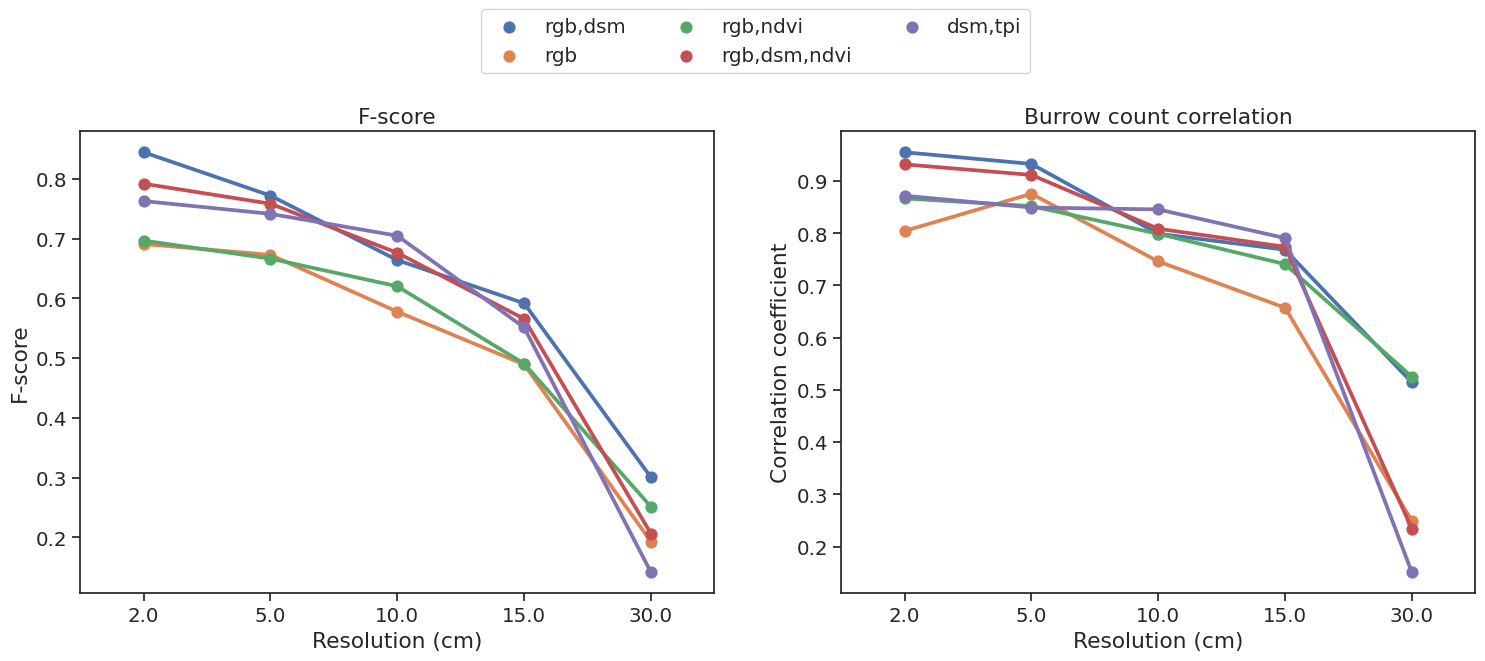

In [24]:
sns.set(font_scale = 1.3)
sns.set_style("ticks")
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)
sns.pointplot(x='test_resolution', y='fscore', 
            hue='inputs', #hue_order=['rgb', 'tpi', 'rgb,tpi', 'rgb,tpi,ndvi', 'rgb,tpi,shade,ndvi'],
            data=df_downscaled_test.sort_values('model_resolution'),
            ci=None,
            ax=axs[0], show_legend=False)
#sns.pointplot(x='test_resolution', y='fscore', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[0], show_legend=False,
#            linestyles='dotted')
axs[0].set_title('F-score')
axs[0].set_ylabel('F-score')

sns.pointplot(x='test_resolution', y='correlation', 
            hue='inputs', #hue_order=['rgb', 'tpi', 'rgb,tpi', 'rgb,tpi,ndvi', 'rgb,tpi,shade,ndvi'],
            data=df_downscaled_test.sort_values('test_resolution'),
            ci=None,
            ax=axs[1], show_legend=False)
#sns.pointplot(x='test_resolution', y='correlation', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[1], show_legend=False,
#            linestyles='dotted')
axs[1].set_title('Burrow count correlation')
axs[1].set_ylabel('Correlation coefficient')
for ax in axs:
    ax.set_xlabel('Resolution (cm)')
    ax.legend().remove()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0, 1.0, 1.1), ncol=3)
plt.savefig('./results_figs/cnn_results_downscaled_test_validation.png',
            dpi=400, bbox_inches='tight', pad_inches=0.1)

In [46]:
test_idx = 1
row = df_val[(df_val['inputs'] == 'rgb,tpi,shade,ndvi') & (df_val['resolution'] == 15.0)].iloc[0]

preprocess = True
print(row[['scaling', 'resolution', 'inputs']])
res = row['resolution']
scaling = row['scaling']
inputs_fnl = row['inputs'].split(',')
# load best saved checkpoint
best_model = torch.load(row['model_path'])
best_model.eval()

newsize = int(round((3000 / res) / 32, 0)) * 32
if newsize > 256:
    newsize = int((3000 / res) / 256) * 256

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats' + scaling + '.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in [x for x in inputs_fnl if x != 'dsm']}

precision_list = []
recall_list = []

burrow_ct_gt = []
burrow_ct_pred = []
tile_id_list = []

ID = df_tiles['ID'][(df_tiles['Train'] == 0) &
                         (df_tiles['Digitize'] == 1)].iloc[test_idx]
print(ID)
# get the path base to the imagery associated with the training tile
if external_path is None:
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
else:
    tilePATH = os.path.join(external_path,
                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    #show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                               out_shape=rgb_out.shape[1:], 
                               transform=transform_out,
                               default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :]) 
    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                     (newsize, newsize),
                     order=1).transpose((2, 0, 1)).astype('int')
    label_mask = resize(label_mask.astype('float32'), (newsize, newsize), anti_aliasing=True, order=1) > 0.5
    label_mask = label_mask.astype('int')
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    #show(label)

pr_mask = np.empty_like(rgb_out[0, :, :])
image_dict = {}
for suffix in inputs_fnl:
    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
        i_out = src_i.read(out_shape=(
            src_i.count,
            src_rgb.meta['height'],
            src_rgb.meta['width']),
                           resampling=Resampling.bilinear)
        image_dict[suffix] = resize(i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1].transpose((1, 2, 0)),
                                    (newsize, newsize),
                                    order=1).transpose((2, 0, 1))
if 'rgb' in inputs_fnl:
    image_dict['rgb'] = rgb_out
if preprocess:
    for i in image_dict:
        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
image_out = np.concatenate(image_list, axis=0)

chunksize = 256
if newsize > 256:
    pr_mask = np.empty_like(rgb_out[0, :, :])
    n_row_chunks = int(np.ceil(rgb_out.shape[1]/chunksize))
    n_col_chunks = int(np.ceil(rgb_out.shape[2]/chunksize))
    image_sub_dict = {}
    for r in range(n_row_chunks):
        if (r + 1) * chunksize > rgb_out.shape[1]:
            r_min = rgb_out.shape[1] - chunksize
            r_max = rgb_out.shape[1]
        else:
            r_min = r * chunksize
            r_max = (r + 1) * chunksize
        for c in range(n_col_chunks):
            if (c + 1) * chunksize > rgb_out.shape[2]:
                c_min = rgb_out.shape[2] - chunksize
                c_max = rgb_out.shape[2]
            else:
                c_min = c * chunksize
                c_max = (c + 1) * chunksize
            image_out_sub = image_out[:, r_min:r_max, c_min:c_max]
            x_tensor = torch.from_numpy(image_out_sub).to(DEVICE).unsqueeze(0)
            if type(best_model) == nn.DataParallel:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            else:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
else:
    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
    if type(best_model) == nn.DataParallel:
        pr_mask = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
    else:
        pr_mask = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

# get regions and properties of the ground truth and predictions
label_labels = label(label_mask)
label_regions = regionprops(label_labels)
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

r_ct_pred = 0
for r in pr_regions:
    if r.area*(res/100)**2 > 0.05:
        y_pr, x_pr = r.centroid
        precision_list.append(label_mask[int(y_pr), int(x_pr)])
        r_ct_pred += 1

r_ct_gt = 0
for r in label_regions:
    y_label, x_label = r.centroid
    recall_list.append(pr_mask[int(y_label), int(x_label)])
    r_ct_gt += 1
burrow_ct_gt.append(r_ct_gt)
burrow_ct_pred.append(r_ct_pred)
tile_id_list.append(ID)

scaling              _downscaled
resolution                  15.0
inputs        rgb,tpi,shade,ndvi
Name: 7, dtype: object
5W_14


In [47]:
precision_list

[1, 1, 0, 1, 1]

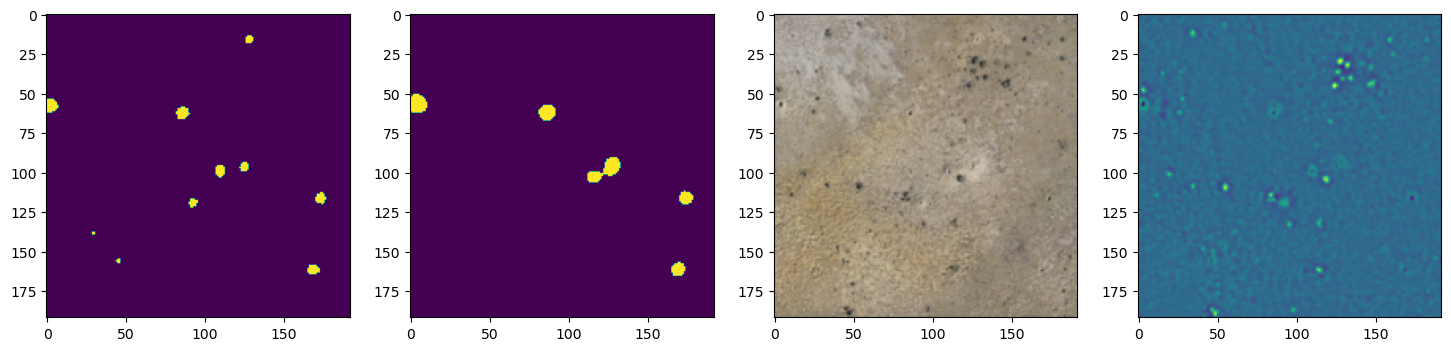

In [40]:
fig, axs = plt.subplots(figsize=(18, 8), ncols=4)
axs[0].imshow(label_mask)
axs[1].imshow(pr_mask)
axs[2].imshow(rgb_out.transpose((1, 2, 0)))
axs[3].imshow(image_dict['tpi'].squeeze())

In [34]:
gdf_polys_sub

,Unnamed: 0,orig_index,Comment,Tile,Trainer,geometry,group,subID
